# Profitability and Volatility Analysis of Apple (AAPL)

This work applies quantitative finance techniques with real data, meeting the requested requirements:

1. Exploratory analysis of daily returns (mean, standard deviation, graphs).
2. Distribution fitting (Normal vs. t-Student) using Q-Q plots and formal tests.
3. Calculation of Value at Risk (VaR) at 1% using the historical method.
4. Calculation of VaR at 1% using the Variance-Covariance method.
5. Calculation of VaR at 1% using Monte Carlo simulation.
6. Calculation of VaR at 1% using Extreme Value Theory (EVT), Hill estimator, and Hill plot.

The data used corresponds to the period from January 1, 2020 to January 1, 2023.


## Importing libraries and data

The data is obtained from Yahoo Finance (or from a previously downloaded CSV file to ensure reproducibility).

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Reading from pre-downloaded CSV (period 2020-2023)
data = pd.read_csv(
    "./data/AAPL.csv",
    skiprows=3,
    names=['Date', 'Close'],
    parse_dates=['Date'],
    index_col='Date'
)

# Calculation of logarithmic returns
data['LogRet'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

C:\Users\miralles\AppData\Local\Temp\ipykernel_22576\1642423349.py:5: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  import scipy.stats as stats


## 1. Exploratory analysis of daily returns

- We calculate the mean and standard deviation of the returns.  
- We plot the daily returns series and its histogram.  

**Interpretation:** These results allow us to evaluate Apple’s average profitability and volatility during the analyzed period.


mean    0.000753
std     0.023255
min    -0.137708
25%    -0.011165
50%     0.000613
75%     0.014054
max     0.113158
Name: LogRet, dtype: float64


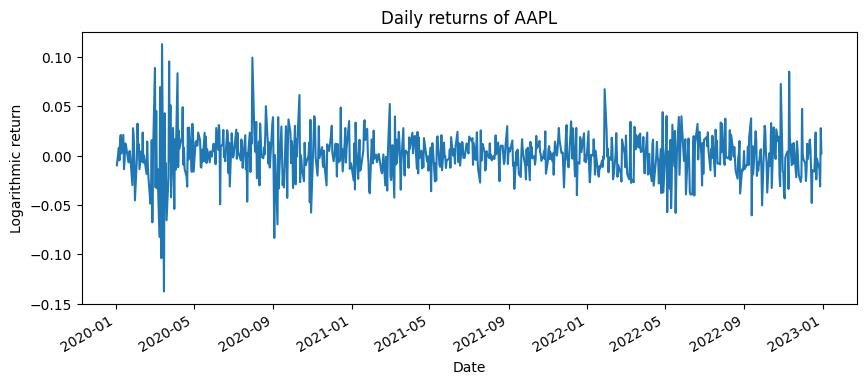

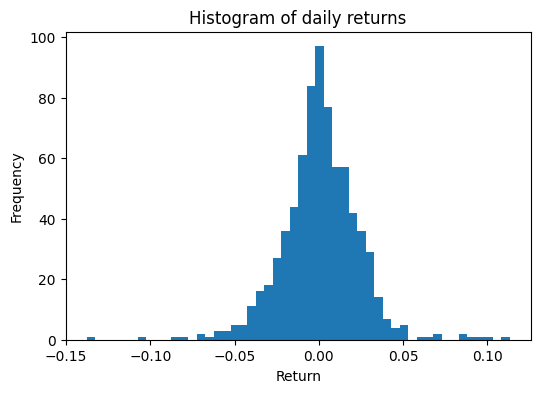

In [2]:
desc = data['LogRet'].describe()
print(desc[['mean','std','min','25%','50%','75%','max']])

data['LogRet'].plot(figsize=(10,4), title='Daily returns of AAPL')
plt.ylabel('Logarithmic return')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data['LogRet'], bins=50)
plt.title('Histogram of daily returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()


## 2. Distribution fitting: Normal vs. t-Student

We compare the fit of returns to two theoretical distributions:

- **Normal:** commonly assumed in classical models.  
- **t-Student:** able to capture heavier tails through its degrees of freedom parameter (*df*).

**Tests used:**  
- **Q-Q plots:** graphically compare the empirical and theoretical quantiles.  
  - Points close to the 45° line indicate a good fit.  
  - Deviations in the tails show how the model under- or overestimates extremes.  
- **Kolmogorov–Smirnov (KS) test:** measures the *largest vertical difference* between the empirical and theoretical cumulative distributions (CDFs).  
  - Sensitive mainly to differences in the **center** of the distribution, where the CDF is steep and data are dense.  
  - Less sensitive in the **tails**, where even large probability errors produce small CDF gaps — hence it tends to undervalue tail mismatches.

**Better alternative:**  
For financial data, where tail risk is crucial, the **Anderson–Darling (AD) test** is more appropriate.  
It weights discrepancies in the tails more heavily, providing a more reliable assessment of how well the distribution captures extreme events.

**Conclusion:**  
The t-Student distribution typically provides a better fit to financial returns, as it accounts for heavy tails and extreme observations that the Normal distribution underestimates.


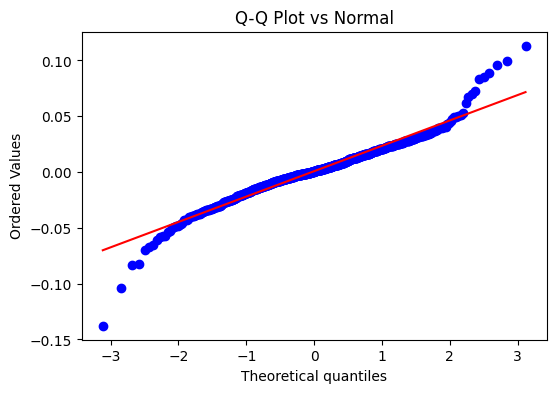

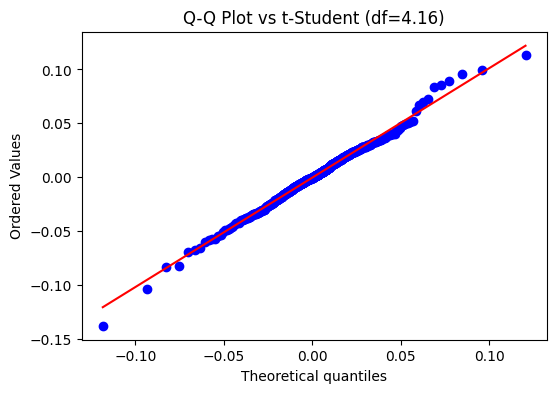

KS Normal: statistic=0.0622, p-value=0.0056
KS t-Student: statistic=0.0195, p-value=0.9313


In [9]:
# Q-Q plot Normal
plt.figure(figsize=(6,4))
stats.probplot(data['LogRet'], dist="norm", plot=plt)
plt.title('Q-Q Plot vs Normal')
plt.show()

# Q-Q plot t-Student
params = stats.t.fit(data['LogRet'])
plt.figure(figsize=(6,4))
stats.probplot(data['LogRet'], dist=stats.t(df=params[0], loc=params[1], scale=params[2]), plot=plt)
plt.title(f"Q-Q Plot vs t-Student (df={params[0]:.2f})")
plt.show()

# KS Tests
d_n, p_n = stats.kstest(data['LogRet'], 'norm', args=(data['LogRet'].mean(), data['LogRet'].std()))
d_t, p_t = stats.kstest(data['LogRet'], 't', args=(params[0], params[1], params[2]))
print(f"KS Normal: statistic={d_n:.4f}, p-value={p_n:.4f}")
print(f"KS t-Student: statistic={d_t:.4f}, p-value={p_t:.4f}")


## 3. Value at Risk (VaR) at 1% – Historical Method

**Definition:** The historical VaR at 1% is the 1st percentile of the empirical distribution of returns.  

**Result:** It represents the maximum expected loss with 99% confidence over a 1-day horizon.


In [4]:
var_hist = np.percentile(data['LogRet'], 1)
print(f"Historical VaR 1%: {var_hist:.4f} (log-return)")
print(f"Historical VaR 1%: {-var_hist*100:.2f}%")


Historical VaR 1%: -0.0592 (log-return)
Historical VaR 1%: 5.92%


## 4. Value at Risk (VaR) at 1% – Variance-Covariance Method

**Assumption:** Returns follow a normal distribution.  

**Formula:** $ VaR = \mu + \sigma z_{0.01} $  

**Comparison with historical method:** This allows us to see the impact of assuming normality versus using real data.


In [5]:
mu = data['LogRet'].mean()
sigma = data['LogRet'].std()
z = stats.norm.ppf(0.01)
var_vc = mu + sigma * z
print(f"VaR Var-Cov 1%: {var_vc:.4f} (log-return)")
print(f"VaR Var-Cov 1%: {-var_vc*100:.2f}%")


VaR Var-Cov 1%: -0.0533 (log-return)
VaR Var-Cov 1%: 5.33%


## 5. Value at Risk (VaR) at 1% – Monte Carlo Simulation

**Methodology:** We simulate 10,000 one-day scenarios using a Geometric Brownian Motion (GBM) model.  

**Result:** The 1st percentile of the simulations corresponds to the VaR.  

**Interpretation:** Useful for incorporating stochastic assumptions and performing scenario analysis.


In [14]:

S0 = data['Close'][-1]
T = 1/252
num_sim = 10000
np.random.seed(42)

mu_ann = mu * 252
sigma_ann = sigma * np.sqrt(252)

rand = np.random.normal(0,1,num_sim)
S1 = S0 * np.exp((mu_ann - 0.5*sigma_ann**2)*T + sigma_ann*np.sqrt(T)*rand)
rets_mc = np.log(S1/S0)
var_mc = np.percentile(rets_mc,1)
print(f"VaR Monte Carlo 1%: {-var_mc*100:.2f}%")


VaR Monte Carlo 1%: 5.35%


## 6. Value at Risk (VaR) at 1% – Extreme Value Theory (EVT)

**Procedure:**  
1. A threshold (5th percentile) is selected to isolate extreme events.  
2. The tail is fitted with a Generalized Pareto Distribution (GPD).  
3. The VaR at 1% is calculated using the Hill estimator.  

**Hill plot:** Used to analyze the stability and convergence of the shape parameter.  

**Interpretation:** Allows for modeling fat tails more robustly than a normal distribution.


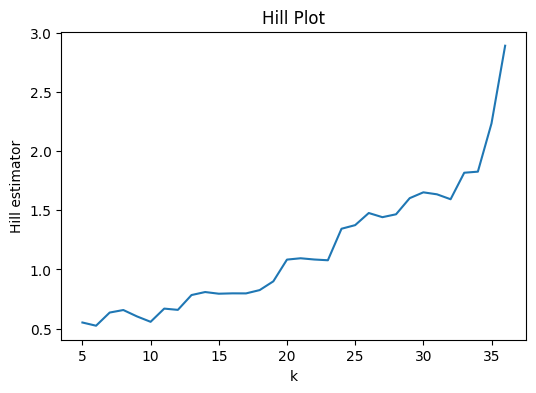

EVT VaR 1%: 1.37% loss


In [26]:
losses = -data['LogRet']
thresh = np.percentile(losses, 95)
excesses = losses[losses > thresh] - thresh

def hill_estimator(x, k):
    x_sorted = np.sort(x)
    return (1/k)*np.sum(np.log(x_sorted[-k:]/x_sorted[-k-1]))

ks = np.arange(5, min(len(excesses)-1,50))
hills = [hill_estimator(excesses.values, k) for k in ks]

plt.figure(figsize=(6,4))
plt.plot(ks, hills)
plt.title('Hill Plot')
plt.xlabel('k')
plt.ylabel('Hill estimator')
plt.show()

xi, loc, beta = stats.genpareto.fit(excesses.values)
alpha = 0.01
N = len(losses)
n_u = len(excesses)
VaR_evt = -thresh + (beta/xi)*((N/n_u*alpha)**(-xi) - 1)
print(f"EVT VaR 1%: {VaR_evt*100:.2f}% loss")


## Conclusions

1. The t-Student distribution provides a better fit to Apple’s returns, confirming heavier tails than a normal distribution.  
2. The historical VaR shows the empirical expected loss at 1%, while the Variance-Covariance VaR is somewhat less extreme due to the normality assumption.  
3. The Monte Carlo simulation produces a VaR similar to the historical one, validating the GBM model for this horizon.  
4. The EVT approach highlights the importance of extreme events and produces a more conservative VaR in the tail.  

**Implication:** The results illustrate how different VaR methodologies can generate distinct estimates and how the choice of tail model (EVT) can significantly impact risk management.